In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import make_scorer, roc_auc_score
from catboost import CatBoostClassifier, Pool
from catboost.text_processing import Tokenizer, Dictionary
from copy import deepcopy
from nltk.tokenize import MWETokenizer
import sqlite3
import sys
import ctypes
import gc
import joblib
import numpy as np
import pandas as pd
import catboost
import heapq
import pickle
import warnings
import random
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
warnings.filterwarnings('ignore')
random.seed(37)

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikitadanilov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load dataset

In [3]:
df = pd.read_csv('../train/codevsotherv1.csv')

In [4]:
df['language'] = df['language'].where(df['language'] == 'OTHER', 'CODE')

In [5]:
df['group'] = df['snippet'].apply(
    lambda x: 'train' 
    if random.random() < 0.8  
    else 'test'
)

In [6]:
df.groupby('language').count().sort_values(by='snippet', ascending=False).reset_index()

,language,snippet,group
0,OTHER,1010386,1010386
1,CODE,844006,844006


### Check split by train/test and by language

In [7]:
def sample_group(group, num):
    return group.sample(min(len(group), num))

NUM = 1854392
# Apply the function to each group
train = df[df.group == 'train'].groupby('language', group_keys=False).apply(lambda x: sample_group(x, num=NUM*0.8)).reset_index(drop=True)
test = df[df.group == 'test'].groupby('language', group_keys=False).apply(lambda x: sample_group(x, num=NUM*0.2)).reset_index(drop=True)
# Display the sampled DataFrame

In [8]:
train

,snippet,language,group
0,<?php\n\n/*\n * This file is part of the Symfo...,CODE,train
1,FROM golang:alpine as builder\n\nLABEL maintai...,CODE,train
2,"""type"": ""ob",CODE,train
3,library ng_dart_ombdbapi;\n\n@MirrorsUsed(targ...,CODE,train
4,"{ name: 'tofront', paramete",CODE,train
...,...,...,...
1483659,विम्बल्डन :- सेरेनाला हरवून अँजेलिक विजेती,OTHER,train
1483660,Партия «РОДИНА»: Мы патриоты и защищаем русски...,OTHER,train
1483661,**ایسنا**\n[شبکه نمایش این هفته چه فیلم‌هایی پ...,OTHER,train
1483662,زمین خوردن\n مهم نیست\nمراقب باش\n کسی...,OTHER,train


In [9]:
meta = []
for language in df.language.unique():
    len_train = len(train[train.language == language])
    len_test = len(test[test.language == language])
    meta.append((len_train + len_test, len_train / (len_train + len_test), language))
df_meta = pd.DataFrame(meta, columns=['num', 'train_share', 'language'])
df_meta.sort_values('num', ascending=False).reset_index()

,index,num,train_share,language
0,1,1010386,0.799695,OTHER
1,0,844006,0.800543,CODE


Text(0.5, 1.0, 'Distribution of Text Lengths')

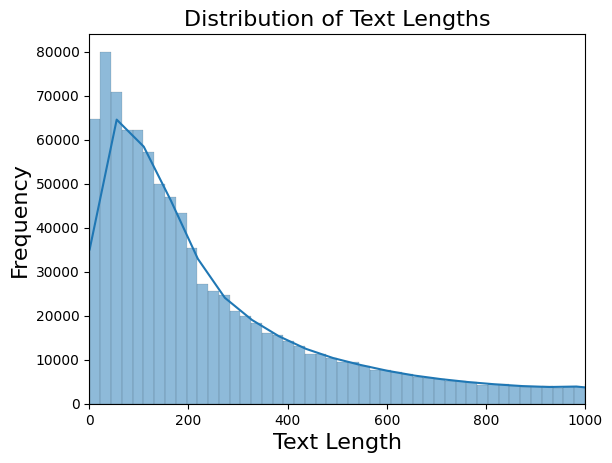

In [282]:
sns.histplot(df[df.language == 'OTHER']['snippet'].apply(len), kde=True, bins=500)  # You can adjust the number of bins as needed

# Set plot labels and title
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.title('Distribution of Text Lengths')

### Grid search by parameters. Catboost classifier with tokenizer

In [297]:
import gc 

tokenizer = Tokenizer(
    lowercasing=True, 
    separator_type='BySense', 
    token_types=['Word', 'Number', 'Punctuation', 'SentenceBreak', 'ParagraphBreak', 'Unknown']
)

train_pool = Pool(
    data=train['snippet'],
    label=train['language'],
    text_features=['snippet'],
    feature_names=['snippet']
)

test_pool = Pool(
    data=test['snippet'],
    label=test['language'],
    text_features=['snippet'],
    feature_names=['snippet']
)
VOCAB_GRID = ["15000"]#, "1500"]#["500", "1500", "5000"]
DEPTH_GRID = [11]#[7, 9, 11]
for DEPTH in DEPTH_GRID:
    for VOCAB in VOCAB_GRID:
        print(DEPTH, VOCAB)
        cat_model = CatBoostClassifier(
            iterations=100,
            eval_metric='Accuracy',
            early_stopping_rounds=20,
            depth=DEPTH,
            # auto_class_weights='Balanced',
            class_weights={'OTHER': 0.9, 'CODE': 0.1}, # know distributin of evalution dataset
            used_ram_limit='60gb',
            thread_count=-1,
            text_processing = {
                "tokenizers" : [{
                    "tokenizer_id" : "Space",
                    "token_types" : ['Word', 'Number', 'Punctuation', 'SentenceBreak', 'ParagraphBreak', 'Unknown'],
                    "lowercasing" : "true",
                    "separator_type" : "BySense",
                    "number_process_policy" : "Replace",
                    "number_token" : "123",
                }],
        
                "dictionaries" : [{
                    "dictionary_id" : "Word",
                    "occurrence_lower_bound": "7",
                    "max_dictionary_size": VOCAB,
                    "gram_order" : "1",
                    "dictionary_type": "Bpe"
                }],
        
                "feature_processing" : {
                    "default" : [{
                        "tokenizers_names" : ["Space"],
                        "dictionaries_names" : ["Word"],
                        "feature_calcers" : ["BoW"] #BoW:top_tokens_count=1000
                    }],
                }
            }
        )
        cat_result = cat_model.fit(
            train_pool,
            plot=True,
            use_best_model=True,
            eval_set=test_pool
        )
        print('train {}'.format(accuracy_score(cat_result.predict(train_pool), train.language)))
        print('test {}'.format(accuracy_score(cat_result.predict(test_pool), test.language)))
        display(pd.DataFrame(classification_report(cat_result.predict(test_pool), test.language, output_dict=True)).transpose())
        cat_result.save_model('../resources/v1_code_vs_other_depth{}_vocab{}.cbm'.format(DEPTH, VOCAB), pool=train_pool, format='cbm')
        # del cat_result
        # gc.collect()

11 15000


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.9556261	test: 0.9552296	best: 0.9552296 (0)	total: 930ms	remaining: 1m 32s
1:	learn: 0.9609805	test: 0.9606838	best: 0.9606838 (1)	total: 1.83s	remaining: 1m 29s
2:	learn: 0.9616313	test: 0.9613615	best: 0.9613615 (2)	total: 2.74s	remaining: 1m 28s
3:	learn: 0.9635331	test: 0.9632384	best: 0.9632384 (3)	total: 3.79s	remaining: 1m 30s
4:	learn: 0.9660892	test: 0.9657996	best: 0.9657996 (4)	total: 4.73s	remaining: 1m 29s
5:	learn: 0.9689247	test: 0.9687556	best: 0.9687556 (5)	total: 5.77s	remaining: 1m 30s
6:	learn: 0.9701424	test: 0.9699146	best: 0.9699146 (6)	total: 6.7s	remaining: 1m 28s
7:	learn: 0.9712716	test: 0.9709794	best: 0.9709794 (7)	total: 7.61s	remaining: 1m 27s
8:	learn: 0.9736471	test: 0.9734022	best: 0.9734022 (8)	total: 8.64s	remaining: 1m 27s
9:	learn: 0.9753956	test: 0.9751880	best: 0.9751880 (9)	total: 9.58s	remaining: 1m 26s
10:	learn: 0.9761956	test: 0.9760721	best: 0.9760721 (10)	total: 10.5s	remaining: 1m 25s
11:	learn: 0.9779

,precision,recall,f1-score,support
CODE,0.896465,0.997719,0.944385,152097.000000
OTHER,0.998281,0.919993,0.957540,219057.000000
accuracy,0.951845,0.951845,0.951845,0.951845
macro avg,0.947373,0.958856,0.950963,371154.000000
weighted avg,0.956557,0.951845,0.952149,371154.000000


### Check model quality (95% accuracy on all dataset)

In [15]:
train_pool = Pool(
    data=df['snippet'],#[0:100],
    text_features=['snippet'],
    feature_names=['snippet']
)

In [14]:
cat_result = CatBoostClassifier()  
cat_result = cat_result.load_model('../resources/v1_code_vs_other_depth11_vocab15000.cbm', format='cbm')
cat_result.classes_

array(['OTHER', 'CODE'], dtype=object)

In [17]:
print('train {}'.format(accuracy_score(cat_result.predict(train_pool), df.language)))
display(pd.DataFrame(classification_report(cat_result.predict(train_pool), df.language, output_dict=True)).transpose())

train 0.9522565886824361


,precision,recall,f1-score,support
CODE,0.896994,0.997895,0.944758,7.586650e+05
OTHER,0.998419,0.920657,0.957963,1.095727e+06
accuracy,0.952257,0.952257,0.952257,9.522566e-01
macro avg,0.947707,0.959276,0.951360,1.854392e+06
weighted avg,0.956924,0.952257,0.952560,1.854392e+06


### Check model quality (95% accuracy on dataset provided by telegram)

In [29]:
from glob import glob

tg_snippets = []
for filename in glob('../train/*/*/*.txt', recursive=True):
    with open(filename) as file:
        snippet = file.read()
        if "OTHER" in filename:
            language = 'OTHER'
        else:
            language = 'CODE'
        tg_snippets.append([snippet, language])

In [35]:
df_tg = pd.DataFrame(tg_snippets, columns=['snippet', 'language'])
tg_pool = Pool(
    data=df_tg['snippet'],#[0:100],
    text_features=['snippet'],
    feature_names=['snippet']
)

In [36]:
print('train {}'.format(accuracy_score(cat_result.predict(tg_pool), df_tg.language)))
display(pd.DataFrame(classification_report(cat_result.predict(tg_pool), df_tg.language, output_dict=True)).transpose())

train 0.9550704037667126


,precision,recall,f1-score,support
CODE,0.879564,0.691449,0.774244,5017.00000
OTHER,0.962319,0.988128,0.975053,40009.00000
accuracy,0.955070,0.955070,0.955070,0.95507
macro avg,0.920942,0.839788,0.874648,45026.00000
weighted avg,0.953098,0.955070,0.952678,45026.00000
